In [158]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

model = pybamm.BaseModel()

In [159]:
z = pybamm.Variable("z") # state of charge
V = pybamm.Variable("V") # terminal voltage (V)
eta = pybamm.Variable("eta") # charge efficiency
i = pybamm.Variable("i") # current (A)
i_R1 = pybamm.Variable("i_R1") # resistor current (A)
Q = pybamm.Variable("Q") # total charge capacity (C)
R_0 = pybamm.Variable("R_0") # equivalent series resistance (Ohm)
R_1 = pybamm.Variable("R_1") # equivalent series resistance (Ohm)
C_1 = pybamm.Variable("C_1") # capactior (F)

In [160]:
ocv_data = pybamm.parameters.process_1D_data("ecm_example_ocv.csv")

def ocv(soc):
    name, (x, y) = ocv_data
    return pybamm.Interpolant(x, y, soc, name)

In [161]:
model.events += [
            pybamm.Event("Minimum SOC", z),
            pybamm.Event("Maximum SOC", 1 - z),
        ]

In [162]:
Q = 5
R_0 = 0.0082
R_1 = 0.0158
C_1 = 38000
i = - 1 # positive = discharge, negative = charge 

def eta(i):
    if i >= 0:
        return 1
    else:
        return 0.99

In [163]:
dzdt = -eta(i) * i / Q
di_R1dt = - i_R1 / (R_1 * C_1) - i / (R_1 * C_1)
V_gov = ocv(z) - i * R_0 - i_R1 * R_1 - V

model.rhs = {z: dzdt, i_R1 : di_R1dt}
model.algebraic = {V: V_gov}

In [164]:
z0 = 0
V0 = 0
i_R10 = 0
model.initial_conditions = {z: z0, V: V0, i_R1: i_R10}
model.variables = {"z": z, "V": V, "i_R1": i_R1}

In [165]:
disc = pybamm.Discretisation()  # default discretisation
disc.process_model(model)
# solver = pybamm.ScipySolver()
solver = pybamm.CasadiSolver(mode="safe", atol=1e-5, rtol=1e-5)
t = np.linspace(0, 10, 100)
solution = solver.solve(model, t)

In [166]:
t_sol, z_sol = solution.t, solution.y  # get solution times and states
z = solution["z"]  # extract and process z and V from the solution
V = solution["V"]

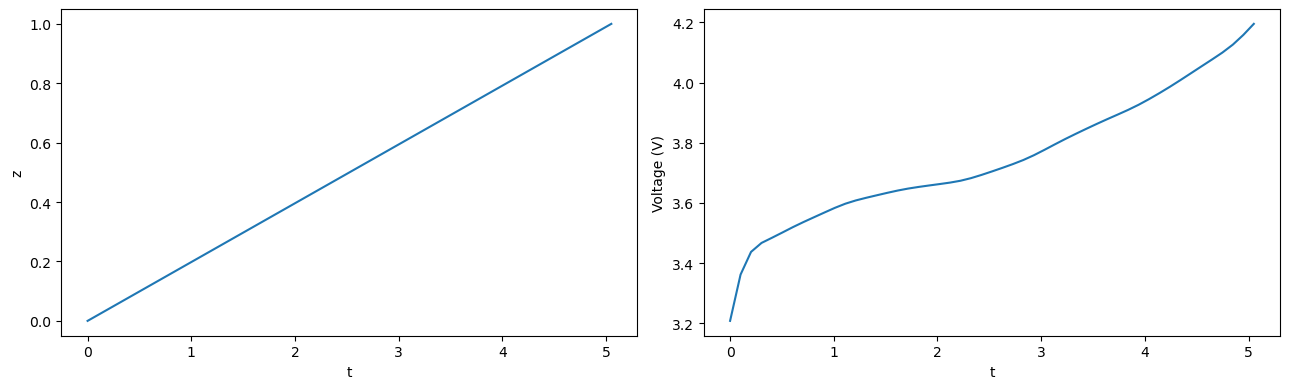

In [167]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.plot(t_sol, z(t_sol))
ax1.set_xlabel("t")
ax1.set_ylabel("z")

ax2.plot(t_sol, V(t_sol))
ax2.set_xlabel("t")
ax2.set_ylabel("Voltage (V)")

# plt.legend(["z"], loc="best")
plt.tight_layout()
plt.show()